# Sujet 3. Influence de la taille des documents pour le clustering

In [255]:
import numpy as np
import pandas as pd
from time import time
import logging
import re
import random

import matplotlib
%matplotlib notebook 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import fetch_20newsgroups

import nltk
import string
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from spherecluster import SphericalKMeans

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score
from coclust.coclustering import CoclustMod
from sklearn.metrics import adjusted_rand_score
from coclust.evaluation.external import accuracy
from sklearn.utils.linear_assignment_ import linear_assignment

from sklearn.model_selection import GridSearchCV

from operator import is_not
from functools import partial

np.random.seed(1994)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

### Jeux de données : the 20 newsgroups by date dataset
`Ng5`, est un échantillon de `Ng20` pour lequel on ne retient que 5 cat égories. 

On pourra utiliser le code Python suivant :


In [3]:
categories = [
   'rec.motorcycles',
   'rec.sport.baseball',
   'comp.graphics',
   'sci.space',
   'talk.politics.mideast'
]
ng5 = fetch_20newsgroups(categories=categories, remove=('headers', 'footers', 'quotes'))
#ng20 = fetch_20newsgroups()

In [4]:
documents = ng5.data
targets = ng5.target
data = ng5

# #############################################################################

print("Loading 20 newsgroups dataset for categories:")
print(categories)

print("\n%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories:
['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.politics.mideast']

2936 documents
5 categories



In [5]:
# Example of document
print (documents[0])


I'd be willing to make two wagers:
1) Snow doesn't win ROY.
2) Mattingly is out of baseball within five years.

I'm skeptical of the first, because I don't think Snow is that good a
player, and he is on a losing team.

I'm skeptical of the second because of his back.  Mattingly is 32 this
year, and how many players play until they are 40?  Not too many, and
most of them didn't have chronic back problems when they were 32.

Could be wrong on either or both, but I think that's the smart way to
bet...


## 1) Corpus Generator + Documents Processing

### Corpus Generator

In [6]:
#Corpus Generator

def get_corpus1(docs):
    """Tronquer les documents en ne prenant que le début (1/3)"""
    sub_corpus = list()
    for doc in docs:
        temp = doc.split()
        nb = len(temp)//3
        sub_corpus.append(' '.join(temp[0:nb]))

    return sub_corpus


def get_corpus2(docs):
    """Retirer des mots aléatoirement, simulant ainsi des mots mal orthographiés"""
    sub_corpus = list()
    for doc in docs:
        temp = doc.split()
        nb = len(temp)//3
        random_words = random.sample(temp, nb)
        ww = (nb*10)//100 #10% du mots mal orthographiés
        for i in range(ww):
            wrong_word_ind = random.randint(0,nb-1)
            w_temp = random_words[wrong_word_ind]
            ind = random.randint(0, len(w_temp)-1)
            
            # Create alphabet list of lowercase letters
            alphabet = []
            for letter in range(97,123):
                alphabet.append(chr(letter))
            
            C = random.sample(alphabet, 1)[0]
            random_words[wrong_word_ind] = w_temp.replace(w_temp[ind], C)
        sub_corpus.append(' '.join(random_words))

    return sub_corpus
  
  

### Natural Language Processing :: Remove stopwords + Stemmer

In [260]:
stopWords = set(stopwords.words('english'))

def check_aps(w):
    if w not in stopWords:
        stm = PorterStemmer().stem(w)
        if (stm.find('\'')!=-1):
            temp = stm.split('\'')
            for partial_word in temp:
                if len(partial_word)>2:
                    return partial_word
        else:
            return stm

def tokenize(text):
    
    r0 = r'[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\'\w\-]+'
    r1 = "(?:\d{,2}\s)?(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*(?:-|\.|\s|,)\s?\d{,2}[a-z]*(?:-|,|\s)?\s?\d{2,4}"
    r2 = "(?:\d{1,2}(?:-|\/))?\d{4}"
    r3 = "(?:\d{1,2})(?:(?:\/|-)\d{1,2})(?:(?:\/|-)\d{2,4})"
    #r4 = "#[0-9A-Z]\d{2,10}"
    pattern_r = r'('+r0+'|'+r1+'|'+r2+'|'+r3+')'
    
    stopWords = set(stopwords.words('english'))
    
    #tokens = re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\'\w\-]+",text)
    words = re.findall(pattern_r,text.lower())
    
    stems = list(map(check_aps, words))
    
    
    
    return list(filter(partial(is_not, None), stems))



## 2~3) Pipelines + Clustering on all Corpus

###  Config Pipeline

In [323]:
def get_pipeline(LSA_n_components, LDA_n_components, steamer):
    if steamer:
        vectorizer_TFIDF = TfidfVectorizer(stop_words='english', use_idf=True, tokenizer=tokenize, min_df=2, max_df=0.95)
    else:
        vectorizer_TFIDF = TfidfVectorizer(norm='l2', stop_words='english', use_idf=True, smooth_idf=False, 
                                           sublinear_tf=False, min_df=2, max_df=0.95)
    
    #============================================ Define PiPELINES ==============================================#
    # Preprocess documents with TfidfVectorizer only
    pipeline_tfidf = Pipeline([ ('tfidf', vectorizer_TFIDF) ])
    # Preprocess documents with Latent Semantic Analysis.
    LSA_pipeline = Pipeline([
        ('tfidf', vectorizer_TFIDF),
        ('svd', TruncatedSVD(n_components=LSA_n_components, algorithm='randomized', n_iter=50, 
                             random_state=2020, tol=0.0))
    ])
    # Preprocess documents with Allocation de Dirichlet Latente (LDA)
    pipeline_LDA = Pipeline([
        ('tfidf', vectorizer_TFIDF),
        ('lda', LatentDirichletAllocation(n_components=LDA_n_components, max_iter=10, learning_method='batch', random_state=2020, n_jobs=-1))
        ])
    
    pipelines = {'tfidf':pipeline_tfidf, 'LSA':LSA_pipeline, 'LDA':pipeline_LDA}
    return pipelines


### Clustering using Spherical k-means

In [ ]:
#=================== Trouvé la meilleure association entre les clusters des deux partitionnements comparés. =========#

def changed_index(labels_true, labels_pred):
    cm = confusion_matrix(labels_true, labels_pred)
    s = np.max(cm)
    cost = s - cm
    indexes = linear_assignment(cost)
    return indexes

def adjusted_labels(labels_true, labels_pred):
    adj_class = []
    
    cm = confusion_matrix(labels_true, labels_pred)
    s = np.max(cm)
    cost = s - cm
    changed_index = linear_assignment(cost)
    
    for j in range(len(labels_pred)):
        for i in range(len(changed_index)):
            if(labels_pred[j] == changed_index[i,1]):
                adj_class.append(changed_index[i,0])
    return adj_class

def miss_classified_docs(target, adjusted_labels):
    target = pd.Series(target)
    adjusted_labels = pd.Series(adjusted_labels)
    diff = target!=adjusted_labels
    diff_ = diff.values
    nb_ms_classed = len(diff_[diff_==True])
    docs_index = (pd.Series(diff_)[diff_==True].index).values
    
    return nb_ms_classed, docs_index


def get_Cluster_scoring(labels_true, labels_pred):
    """Mesurer la différence entre les résultats de clustering"""
    #best_index = changed_index(labels_true, labels_pred)
    adjusted_classes = adjusted_labels(labels_true, labels_pred)
    
    Acc = accuracy(labels_true, adjusted_classes)
    NMI = normalized_mutual_info_score(labels_true, adjusted_classes)
    ARI = adjusted_rand_score(labels_true, adjusted_classes)
    #print ("\nAccuracy = %f"%Acc)
    #print ("NMI = %f"%NMI) 
    #print ("ARI = %f"%ARI)
    return [Acc, NMI, ARI]



#============================================ Clustering Performance ==============================================#

def clustering_performance(documents, targets, corpus_types, pipelines, steamer):
    
    cluster_models = {'doc':{'tfidf':{'Cluster model':None}, 'LSA':{'Cluster model':None}, 'LDA':{'Cluster model':None}}, 
                      'top':{'tfidf':{'Cluster model':None}, 'LSA':{'Cluster model':None}, 'LDA':{'Cluster model':None}}, 
                      'random':{'tfidf':{'Cluster model':None}, 'LSA':{'Cluster model':None}, 'LDA':{'Cluster model':None}}}
    transformed_data = {'doc':{'tfidf':{'matrix':None}, 'LSA':{'matrix':None}, 'LDA':{'matrix':None}}, 
                      'top':{'tfidf':{'matrix':None}, 'LSA':{'matrix':None}, 'LDA':{'matrix':None}}, 
                      'random':{'tfidf':{'matrix':None}, 'LSA':{'matrix':None}, 'LDA':{'matrix':None}}}
    resume = []
    
    for corpus_type in corpus_types:
        if corpus_type == 'doc':
            data = documents  
        elif corpus_type == 'top':
            data = get_corpus1(documents)
        elif corpus_type == 'random':
            data = get_corpus2(documents)
        
        for Type in pipelines.keys():
            pipeline = pipelines[Type] 
            matrix = pipeline.fit_transform(data)
            skm = SphericalKMeans(n_clusters=5, random_state=2020, n_jobs=-1, 
                                  n_init=10, max_iter=1000, normalize=True)
            skm.fit(matrix)
            #without steamer without headers
            print("Clustering scores using SphericalKMeans on "+Type+" of "+corpus_type+" words:")
            scores = get_Cluster_scoring(targets, skm.labels_)

            cluster_models[corpus_type][Type]['Cluster model'] = skm
            transformed_data[corpus_type][Type]['matrix'] = matrix

            scores.append(Type)
            scores.append(corpus_type)
            if Type=='tfidf':
                scores.append(None)
            elif Type=='LSA':
                scores.append(int(pipeline.named_steps['svd'].n_components))
            elif Type=='LDA':
                scores.append(int(pipeline.named_steps['lda'].n_components))
            scores.append(steamer)

            resume.append(scores)
        
    resume = pd.DataFrame(resume,columns=['Accuracy', 'NMI', 'ARI', 'From', 'Corpus type',
                                          'n_components', 'Steamer'])
    
    return transformed_data, cluster_models, resume
        


#### choice LSA dimension using SVD singular value

In [337]:
vectorizer_TFIDF = TfidfVectorizer(norm='l2', stop_words='english', use_idf=True, smooth_idf=False, 
                                           sublinear_tf=False, min_df=2, max_df=0.95)
Matrix_tfidf = vectorizer_TFIDF.fit_transform(documents)
Matrix = Matrix_tfidf.toarray()
u, s, vh = np.linalg.svd(Matrix, full_matrices=False)

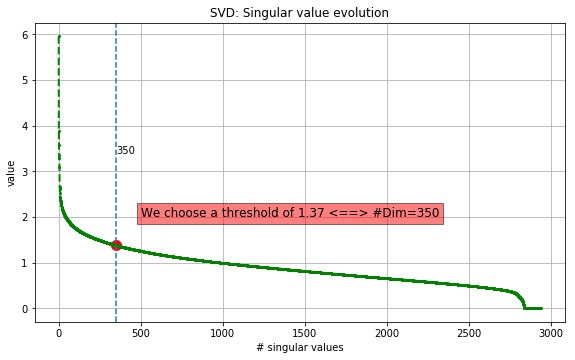

In [341]:
# Data for plotting
t = range(1,len(s)+1)

fig, ax = plt.subplots()
ax.plot(t, s, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=2)

ax.set(xlabel='# singular values', ylabel='value',
       title='SVD: Singular value evolution')
ax.grid()

fig.set_size_inches(9.5, 5.5)
plt.axvline(x=350, linestyle="--")
ax.annotate("350", (350, s[350]+2))
ax.scatter(350, s[350], c="red", marker='o', linewidths=5)
ax.text(x=500, y=2, s='We choose a threshold of 1.37 <==> #Dim=350', fontsize=12, bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='left')
#fig.savefig("singular values.png")
plt.show()

#### Fix params

In [324]:
#============================================ set Params ==============================================#
LSA_n_components = 350
LDA_n_components = 400
#============================================ get PiPELINES ==============================================#
pipelines_with_streamer = get_pipeline(LSA_n_components, LDA_n_components, steamer=True)
pipelines_without_streamer = get_pipeline(LSA_n_components, LDA_n_components, steamer=False)

### Mesurer la différence entre plusieurs résultats de clustering

##### Without Steamer

In [326]:
transformed_data, cluster_models, resume = clustering_performance(documents, targets, ['doc', 'top', 'random'],
                                                                  pipelines_without_streamer, steamer=False)

Clustering scores using SphericalKMeans on tfidf of doc words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LSA of doc words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LDA of doc words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on tfidf of top words:
Clustering scores using SphericalKMeans on LSA of top words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LDA of top words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on tfidf of random words:
Clustering scores using SphericalKMeans on LSA of random words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LDA of random words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [327]:
resume

,Accuracy,NMI,ARI,From,Corpus type,n_components,Steamer
0,0.801431,0.565661,0.550434,tfidf,doc,NaN,False
1,0.840599,0.608500,0.637489,LSA,doc,350.0,False
2,0.318801,0.064764,0.057306,LDA,doc,400.0,False
3,0.424046,0.135604,0.136347,tfidf,top,NaN,False
4,0.208447,0.035625,-0.000012,LSA,top,350.0,False
5,0.260559,0.022249,0.018025,LDA,top,400.0,False
6,0.445504,0.158786,0.124491,tfidf,random,NaN,False
7,0.505109,0.211231,0.202215,LSA,random,350.0,False
8,0.297684,0.039977,0.028001,LDA,random,400.0,False


##### With Steamer

In [328]:
transformed_data_s, cluster_models_s, resume_s = clustering_performance(documents, targets, ['doc', 'top', 'random'],
                                                                  pipelines_with_streamer, steamer=True)

/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Clustering scores using SphericalKMeans on tfidf of doc words:
Clustering scores using SphericalKMeans on LSA of doc words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LDA of doc words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on tfidf of top words:
Clustering scores using SphericalKMeans on LSA of top words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LDA of top words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on tfidf of random words:
Clustering scores using SphericalKMeans on LSA of random words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Clustering scores using SphericalKMeans on LDA of random words:


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [329]:
resume_s

,Accuracy,NMI,ARI,From,Corpus type,n_components,Steamer
0,0.821866,0.569270,0.604409,tfidf,doc,NaN,True
1,0.809946,0.570602,0.576685,LSA,doc,350.0,True
2,0.390327,0.144141,0.125052,LDA,doc,400.0,True
3,0.479564,0.209804,0.173725,tfidf,top,NaN,True
4,0.558583,0.264111,0.267267,LSA,top,350.0,True
5,0.315736,0.048178,0.043222,LDA,top,400.0,True
6,0.205041,0.014913,0.000021,tfidf,random,NaN,True
7,0.589578,0.248401,0.244724,LSA,random,350.0,True
8,0.247616,0.011878,0.008135,LDA,random,400.0,True


## 4) Identifier les documents dont la classification diffère

##### Show Miss Classified Docs in Confusion Matrix

In [330]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    %matplotlib inline
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def show_adjusted_confusion_matrix(class_names, labels_true, labels_pred, title):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels_true, labels_pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title=title)

    plt.show()

##### Calculat Miss Classified Docs in all corpus

In [331]:
def Miss_Classification_detail(cluster_models, targets):
    details = []
    for corpus_type in cluster_models.keys():
        # doc or top or random
        skm_labels = []
        # Predict labels using SK-Means with all pipelines
        for pipeline_type in cluster_models[corpus_type].keys():
            # tfidf and LSA only
            skm = cluster_models[corpus_type][pipeline_type]['Cluster model']
            skm_labels.append(skm.labels_)
        
        labels_tfidf = skm_labels[0]
        labels_LSA = skm_labels[1]

        # Adjusting labels
        adjust_labels_tfidf = adjusted_labels(targets, labels_tfidf)
        adjust_labels_LSA = adjusted_labels(targets, labels_LSA)

        # Miss-classified docs in corpus_type
        #### Model1 (LSA) vs. True Labels:
        nb_ms_classed_LSA, docs_index_LSA = miss_classified_docs(targets, adjust_labels_tfidf)
        #### Model2 (tfidf) vs. True Labels:
        nb_ms_classed_tfidf, docs_index_tfidf = miss_classified_docs(targets, adjust_labels_LSA)
        #### Model1(LSA) vs. Model2 (tfidf) :
        nb_ms_classed_tfidf_LSA, docs_index_tfidf_LSA = miss_classified_docs(adjust_labels_tfidf, adjust_labels_LSA)
        
        tfidf_vs_targets = nb_ms_classed_tfidf/len(targets)*100
        LSA_vs_targets = nb_ms_classed_LSA/len(targets)*100
        LSA_vs_tfidf = nb_ms_classed_tfidf_LSA/len(targets)*100
        details.append([tfidf_vs_targets, LSA_vs_targets, LSA_vs_tfidf, 
                        nb_ms_classed_tfidf, nb_ms_classed_LSA, nb_ms_classed_tfidf_LSA, corpus_type])
        
    details = pd.DataFrame(details,columns=['tfidf_vs_targets(%)', 'LSA_vs_targets(%)', 'LSA_vs_tfidf(%)', 
                                           'tfidf_vs_targets(docs)', 'LSA_vs_targets(docs)', 'LSA_vs_tfidf(docs)',
                                          'corpus_type'])
    return details

In [332]:
details = Miss_Classification_detail(cluster_models, targets)
details_s = Miss_Classification_detail(cluster_models_s, targets)

##### Without Steamer

In [333]:
details

,tfidf_vs_targets(%),LSA_vs_targets(%),LSA_vs_tfidf(%),tfidf_vs_targets(docs),LSA_vs_targets(docs),LSA_vs_tfidf(docs),corpus_type
0,15.940054,19.856948,14.543597,468,583,427,doc
1,79.155313,57.595368,78.371935,2324,1691,2301,top
2,49.489101,55.449591,53.814714,1453,1628,1580,random


##### With Steamer

In [336]:
details_s

,tfidf_vs_targets(%),LSA_vs_targets(%),LSA_vs_tfidf(%),tfidf_vs_targets(docs),LSA_vs_targets(docs),LSA_vs_tfidf(docs),corpus_type
0,19.005450,17.813351,17.779292,558,523,522,doc
1,44.141689,52.043597,54.461853,1296,1528,1599,top
2,41.042234,79.495913,83.310627,1205,2334,2446,random




#### More details :: Miss Classified Docs In (corpus_type = doc)

###### Model 1 with LSA

In [286]:
Matrix_LSA = pipelines_without_streamer['LSA'].fit_transform(documents)

skm_LSA = SphericalKMeans(n_clusters=5, random_state=2020, n_jobs=-1, n_init=10, max_iter=1000, normalize=True)
skm_LSA.fit(Matrix_LSA)

#without steamer without headers
scores_LSA = get_Cluster_scoring(targets, skm_LSA.labels_)


Accuracy = 0.840599
NMI = 0.608500
ARI = 0.637489


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


###### Model 2 with tfidf only

In [287]:
Matrix_tfidf = pipelines_without_streamer['tfidf'].fit_transform(documents)

skm_tfidf = SphericalKMeans(n_clusters=5, random_state=2020, n_jobs=-1, n_init=10, max_iter=1000, normalize=True)
skm_tfidf.fit(Matrix_tfidf)

#without steamer without headers
scores_tfidf = get_Cluster_scoring(targets, skm_tfidf.labels_)


Accuracy = 0.801431
NMI = 0.565661
ARI = 0.550434


/home/gpuadmin/.conda/envs/py3_ramah/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [316]:
#Matrix_tfidf
#Matrix_LSA

# Predicted using SK-Means
labels_tfidf = skm_tfidf.labels_
labels_LSA = skm_LSA.labels_

# Adjusting labels
adjust_labels_tfidf = adjusted_labels(targets, labels_tfidf)
adjust_labels_LSA = adjusted_labels(targets, labels_LSA)

# Miss-classified docs in all corpus 1
#### Model1 (LSA) vs. True Labels:
nb_ms_classed_LSA, docs_index_LSA = miss_classified_docs(targets, adjust_labels_tfidf)
#### Model2 (tfidf) vs. True Labels:
nb_ms_classed_tfidf, docs_index_tfidf = miss_classified_docs(targets, adjust_labels_LSA)
#### Model1(LSA) vs. Model2 (tfidf) :
nb_ms_classed_tfidf_LSA, docs_index_tfidf_LSA = miss_classified_docs(adjust_labels_tfidf, adjust_labels_LSA)

In [318]:
print('Miss Classified Documents using SK-means(tfidf): {0:.2f} %'.format(nb_ms_classed_tfidf/len(targets)*100))
print('Miss Classified Documents using SK-means(LSA on tfidf): {0:.2f} %'.format(nb_ms_classed_LSA/len(targets)*100))
print('Miss Classified Documents between SK-means(LSA on tfidf) and SK-means(tfidf): {0:.2f} %'.format(nb_ms_classed_tfidf_LSA/len(targets)*100))

Miss Classified Documents using SK-means(tfidf): 15.94 %
Miss Classified Documents using SK-means(LSA on tfidf): 19.86 %
Miss Classified Documents between SK-means(LSA on tfidf) and SK-means(tfidf): 14.54 %


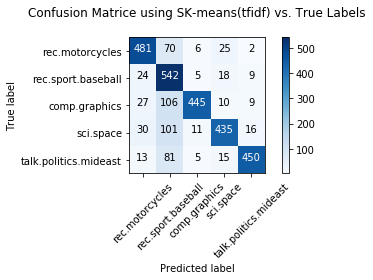

Summary : Miss Classified Documents using SK-means(tfidf): 15.94 %



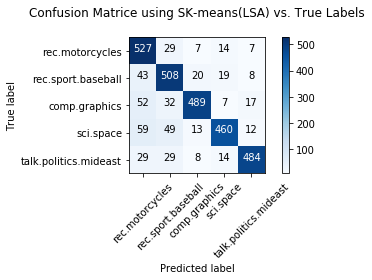

Summary : Miss Classified Documents using SK-means(LSA on tfidf): 19.86 %



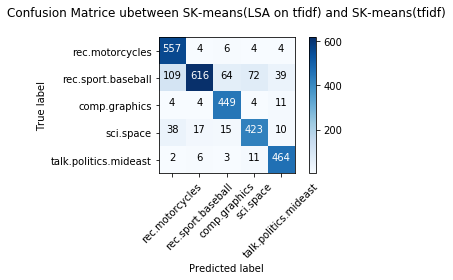

Summary : Miss Classified Documents between SK-means(LSA on tfidf) and SK-means(tfidf): 14.54 %



In [319]:
#### Confusion Matrice using SK-means(tfidf) vs. True Labels
show_adjusted_confusion_matrix(categories, targets, adjust_labels_tfidf, 
                               'Confusion Matrice using SK-means(tfidf) vs. True Labels\n')
print('Summary : Miss Classified Documents using SK-means(tfidf): {0:.2f} %\n'.format(nb_ms_classed_tfidf/len(targets)*100))

#### Confusion Matrice using SK-means(LSA) vs. True Labels
show_adjusted_confusion_matrix(categories, targets, adjust_labels_LSA, 
                               'Confusion Matrice using SK-means(LSA) vs. True Labels\n')
print('Summary : Miss Classified Documents using SK-means(LSA on tfidf): {0:.2f} %\n'.format(nb_ms_classed_LSA/len(targets)*100))

#### Confusion Matrice using SK-means(LSA) vs. True Labels
show_adjusted_confusion_matrix(categories, adjust_labels_tfidf, adjust_labels_LSA, 
                               'Confusion Matrice ubetween SK-means(LSA on tfidf) and SK-means(tfidf)\n')
print('Summary : Miss Classified Documents between SK-means(LSA on tfidf) and SK-means(tfidf): {0:.2f} %\n'.format(nb_ms_classed_tfidf_LSA/len(targets)*100))